# Simple Bainary Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
X, y = digits["data"], digits['target']
X.shape

(1797, 64)

In [4]:
y.shape

(1797,)

In [5]:
8 * 8

64

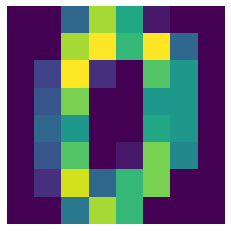

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(8, 8)
plt.imshow(some_digit_image)
plt.axis("off")
plt.show()

In [7]:
y[0]

0

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [9]:
X_train.shape

(1527, 64)

In [10]:
X_test.shape

(270, 64)

## Simple Binary Classification

For simplicity we'll build a simple classifier that only detects if an image has 5 in it or not. Since answer is True or False this will be a binary classification.

In [11]:
# True for all 5s, False for all other digits

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
y_train_5

array([False,  True, False, ..., False, False, False])

### Simple Logistic Regression

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 10)
log_reg.fit(X_train, y_train)

### Stochastic Gradient Descent Classifier

This is good classifier to start with it as it large datasets efficiently and handles training instances independently.

In [13]:
from sklearn.linear_model import SGDClassifier
import time

start_time = time.time()
sgd_clf = SGDClassifier(max_iter = 100, tol = 1e-3, random_state = 42)
sgd_clf.fit(X_train, y_train_5)
end_time = time.time()

print("time :", end_time - start_time)

time : 0.01477193832397461


In [14]:
sgd_clf.score(X_test, y_test_5)

0.9925925925925926

In [15]:
# some_digit = 5

sgd_clf.predict([some_digit])

array([False])

### Performance Measures

#### Measuring Accuracy Using Cross-Validation
K-fold cross-validation means splitting the training set into K folds(in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [16]:
from sklearn.model_selection import cross_val_score

start_time = time.time()
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")
end_time = time.time()

print("cross_val_score: ", scores)
print("time :", end_time - start_time)

cross_val_score:  [0.99607073 0.98821218 0.99017682]
time : 0.03911185264587402


We get accuracy for each fold = 96.76%, 95.99%, 96.6%

#### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B.

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

confusion_matrix(y_train_5, y_train_pred)

array([[1373,    5],
       [   8,  141]])

1373 : True negative , 5 : False positive , 8 : False negative , 141 : True positive

In [18]:
# ideal confusion matrix has non_zero elements only in the diagonal like this...

confusion_matrix(y_train_5, y_train_5)

array([[1378,    0],
       [   0,  149]])

#### Precision and Recall

* Precision: accuracy of the positive predictions
* Recall: the ratio of positive instances that are correctly detected by the classifier

These are fundamental tools to evaluate and fine tune a classifier.
* If our classifier claims that "these 10 images have an apple in it" but in reality only 8 images contain apples then the precision is 0.8 or 80%
* If we give 10 images with apples to our classifier but it recognaizes only 7 and rejects 3 then its recall is 0.7 or 70%
* If we aim for higher precision we compromise on recall and vice versa
* Ideally we want both high precision and high recall. But we need to find a thresholdvalue so that there is a trade-off

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.9657534246575342

In [20]:
recall_score(y_train_5, y_train_pred)

0.9463087248322147

#### F1-Score

It is the harmonic mean of precision and recall and a more convenient way to compare a classifier.

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.9559322033898304

##### So how do we know which threshold to use for our classifier?

* First we need to find the decision scores of our classifier by calling for 'decision function' instead of accuracy
* Then we plot Precision and Recall curves
* From that curve we can conclude a threshold score

In [22]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])

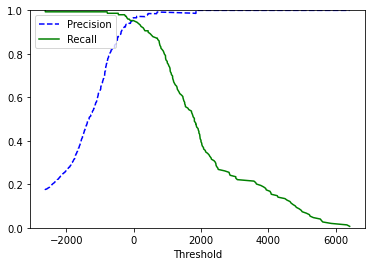

In [24]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

We should also analyse how precision vs recall works without threshold for a better understanding.

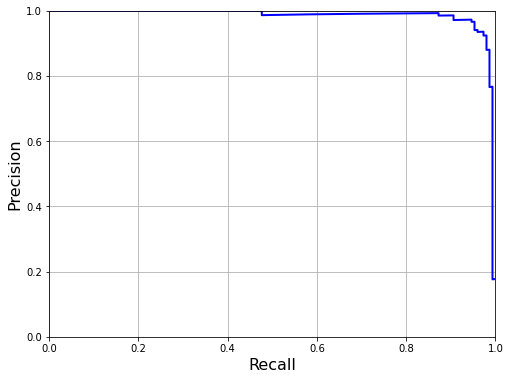

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

See how the recall falls beyond 80% precision? Let's aim for 90% precision by setting threshold value to and see our precision and recall scores.

In [26]:
y_train_pred_90 = (y_scores >50)
precision_score(y_train_5, y_train_pred_90)

0.9657534246575342

In [27]:
recall_score(y_train_5, y_train_pred_90)

0.9463087248322147

#### ROC Curve

* ROC is Receiver Operating Characteristic
* Sensitivity = Recall = True Positive Rate
* Specificity = True Negative Rate
* False Positive Rate = 1 - Specificity
* The more the area under the curve the better our classifier

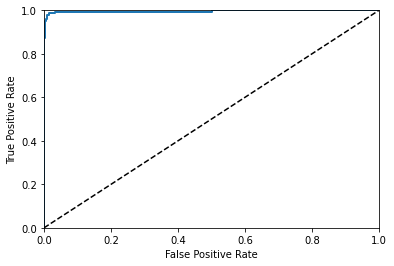

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr, "Roc Curve")
plt.show()

We can calculate area under this curve like this:

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9956361227730102